### Setup

Import all relevant libraries.

In [5]:
import numpy as np
import tensorflow as tf
import keras

import os
import datetime
import time as timer
import sys
import imp

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import models as M
import utils as U
import dataset

imp.reload(M)
imp.reload(U)


<module 'utils' from '/Users/mghifary/Work/Code/AI/keras-poc/utils.py'>

### Constants

Some predefined constants to configure the data, model, and training settings.

In [6]:
EPOCH = 30
BATCH = 128

DATADIR = "/Users/mghifary/Work/Code/AI/data"
MODELDIR = "/Users/mghifary/Work/Code/AI/models"

### Load dataset

In [13]:
# Load dataset
(x_train, y_train), (x_test, y_test) = dataset.load_data()

(n_train, dx1, dx2) = x_train.shape
n_test = x_test.shape[0]

x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

data_train = np.concatenate([x_train, x_test], axis=0)
data_train = np.expand_dims(data_train, -1)

ds_train = tf.data.Dataset.from_tensor_slices(data_train)
ds_train = ds_train.shuffle(buffer_size=1024).batch(BATCH)


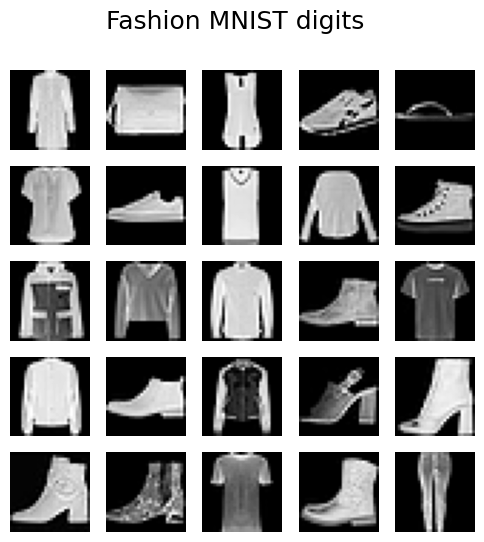

In [16]:
# Visualize dataset
U.visualize_dataset(ds_train, "Fashion MNIST digits", n_samples=25)

### Train VAE

In [17]:
# Setup summary writers for tensorboard
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/vae-fashionmnist/' + current_time + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

In [18]:
latent_dim = 2
encoder = M.create_conv_encoder(input_shape=(28, 28, 1), latent_dim=latent_dim)
decoder = M.create_conv_decoder(latent_dim=latent_dim)
model = M.VAE(encoder, decoder)

optimizer = keras.optimizers.legacy.Adam(3e-4)
modelpath = os.path.join(MODELDIR, "vae-conv_fashionmnist.h5")

model.build(input_shape=(None, 28, 28, 1))

In [19]:
model.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

In [20]:
model.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         289 

In [21]:
model.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        [(None, 2),               69076     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         65089     
                                                                 
Total params: 134171 (524.11 KB)
Trainable params: 134165 (524.08 KB)
Non-trainable params: 6 (24.00 Byte)
_________________________________________________________________


In [22]:
# Training on batch function
@tf.function
def train_vae_on_batch(model, optimizer, inputs):
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = model.encoder(inputs, training=True)
        reconstruction = model.decoder(z, training=True)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(inputs, reconstruction), axis=(1 , 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss
        
    grads = tape.gradient(total_loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    model.total_loss_tracker.update_state(total_loss)
    model.reconstruction_loss_tracker.update_state(reconstruction_loss)
    model.kl_loss_tracker.update_state(kl_loss)

In [23]:
# Do training
for epoch in range(EPOCH):
    # Mini-batch training
    train_duration = 0.0
    for step, x in enumerate(ds_train):
        start_t = timer.time()
        train_vae_on_batch(model, optimizer, x)
        elapsed_t = timer.time() - start_t

        train_duration += elapsed_t

    tloss = model.total_loss_tracker.result()
    rloss = model.reconstruction_loss_tracker.result()
    klloss = model.kl_loss_tracker.result()

    
    # Store log
    with train_summary_writer.as_default():
        tf.summary.scalar('total_loss', tloss, step=epoch)
        tf.summary.scalar('reconstruction_loss', rloss, step=epoch)
        tf.summary.scalar('kl_loss', klloss, step=epoch)

    print(f"Epoch {epoch+1} - Training [total_loss: {tloss:.5f}, reconstruction_loss: {rloss:.5f}, kl_loss: {klloss:.5f}] ({train_duration:.3f} secs)")

    # Save model
    model.save_weights(modelpath, overwrite=True, save_format=None, options=None)

Epoch 1 - Training [total_loss: 371.51532, reconstruction_loss: 365.31604, kl_loss: 6.19910] (16.361 secs)
Epoch 2 - Training [total_loss: 339.45468, reconstruction_loss: 330.92618, kl_loss: 8.52829] (17.033 secs)
Epoch 3 - Training [total_loss: 323.97522, reconstruction_loss: 314.98981, kl_loss: 8.98486] (18.215 secs)
Epoch 4 - Training [total_loss: 314.07516, reconstruction_loss: 305.10748, kl_loss: 8.96714] (17.856 secs)
Epoch 5 - Training [total_loss: 307.08975, reconstruction_loss: 298.28934, kl_loss: 8.79977] (17.333 secs)
Epoch 6 - Training [total_loss: 301.93289, reconstruction_loss: 293.31091, kl_loss: 8.62129] (17.036 secs)
Epoch 7 - Training [total_loss: 297.99982, reconstruction_loss: 289.53610, kl_loss: 8.46380] (16.925 secs)
Epoch 8 - Training [total_loss: 294.89297, reconstruction_loss: 286.55957, kl_loss: 8.33325] (16.355 secs)
Epoch 9 - Training [total_loss: 292.36691, reconstruction_loss: 284.14505, kl_loss: 8.22184] (16.062 secs)
Epoch 10 - Training [total_loss: 290.